# Setup model and install packages

In [1]:
# ] instantiate # remove comments to install packages

In [2]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, Plots, DiffEqBase, Symbolics

# Model equations and steady states

In [3]:
∞ = Inf
@variables α, β, ρ, δ, σ, Ω_1
@variables t::Integer, k(..), z(..), c(..), q(..)

x = [k, z]
y = [c, q]
p = [α, β, ρ, δ, σ, Ω_1]

H = [1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)^(α - 1) + (1 - δ)),
     c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
     q(t) - exp(z(t)) * k(t)^α,
     z(t + 1) - ρ * z(t)]

steady_states = [k(∞) ~ (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 z(∞) ~ 0,
                 c(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)) -
                        δ * (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 q(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1))]

Γ = reshape([σ], 1, 1)
η = reshape([0; -1], length(x), 1) # η is n_x * n_ϵ matrix

Q = zeros(2, length(x) + length(y))
Q[1, 1] = 1.0
Q[2, 3] = 1.0

Ω = [Ω_1, Ω_1]

# Generates the files and includes if required.  If the model is already created, then just loads
model_rbc = @make_and_include_perturbation_model("rbc_notebook_example", H, (; t, y, x, p, steady_states, Γ, Ω, η, Q)) # Convenience macro.  Saves as ".function_cache/rbc_notebook_example.jl"

# After generation could just include directly with the following code
# isdefined(Main, :rbc_notebook_example) || include(joinpath(pkgdir(DifferentiableStateSpaceModels),
#                                              "test/generated_models/rbc_notebook_example.jl"))


# Alternatively, this is the same as a prebuilt example
# model_rbc = @include_example_module(DifferentiableStateSpaceModels.Examples.rbc_observables)  # or use prebuilt model

Perturbation Model: n_y = 2, n_x = 2, n_p = 6, n_ϵ = 1, n_z = 2
 y = [:c, :q] 
 x = [:k, :z] 
 p = [:α, :β, :ρ, :δ, :σ, :Ω_1]

In [4]:
model_rbc.mod.m.H_latex # model_H_latex(model_rbc)

L"$\begin{equation}
\left[
\begin{array}{c}
\frac{ - \beta \left( 1 - \delta + \left( k\left( 1 + t \right) \right)^{-1 + \alpha} \alpha e^{z\left( 1 + t \right)} \right)}{c\left( 1 + t \right)} + \frac{1}{c\left( t \right)} \\
 - q\left( t \right) - \left( 1 - \delta \right) k\left( t \right) + c\left( t \right) + k\left( 1 + t \right) \\
 - \left( k\left( t \right) \right)^{\alpha} e^{z\left( t \right)} + q\left( t \right) \\
 - \rho z\left( t \right) + z\left( 1 + t \right) \\
\end{array}
\right]
\end{equation}
$"

In [5]:
model_rbc.mod.m.steady_states_latex # model_steady_states_latex(model_rbc)

L"$\begin{align}
k\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \\
z\left( \infty \right) =& 0 \\
c\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}} - \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \delta \\
q\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}}
\end{align}
$"

# Solving Perturbations

In [6]:
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC
sol_2 = generate_perturbation(model_rbc, p_d, p_f, Val(2)) # Solution to the second-order RBC

# Query the solution
sol.y ≈ [5.936252888048733, 6.884057971014498]

true

In [7]:
sol.x ≈ [47.39025414828825, 0.0]

true

In [8]:
sol.retcode == :Success

true

# Derivatives of the Perturbation Solvers

In [9]:
function f(params; m, p_f)
    p_d = (α=params[1], β=params[2])  # Differentiated parameters
    sol = generate_perturbation(m, p_d, p_f) # Default is first-order.
    return sum(sol.A) # An ad-hoc example: reducing the law-of-motion matrix into one number
end

# To call it
m = PerturbationModel(Main.rbc_notebook_example)
p_f = (ρ=0.2, δ=0.02, σ=0.01, Ω_1=0.01)
param_val = [0.5, 0.95] # as a vector, but not required
f(param_val; m, p_f) # Function works on its own, calculating perturbation

7.366206154679088

In [10]:
# Query the solution
f(param_val; m, p_f) ≈ 7.366206154679124

true

In [11]:
# But you can also get its gradient with Zygote/etc.
gradient(params -> f(params; m, p_f), param_val)

([61.419683765473486, 106.44095661062124],)

# Using Solution Cache

In [12]:
function f2(p_d; m, p_f, cache)
    sol = generate_perturbation(m, p_d, p_f; cache) # Default is first-order.
    return sum(sol.A) # An ad-hoc example: reducing the law-of-motion matrix into one number
end

# To call it
m = PerturbationModel(Main.rbc_notebook_example)
p_d = (α=0.5, β=0.95)  # Differentiated parameters
p_f = (ρ=0.2, δ=0.02, σ=0.01, Ω_1=0.01)
cache = SolverCache(m, Val(1), p_d)
f2(p_d; m, p_f, cache) # Function works on its own, calculating perturbation

7.366206154679088

In [13]:
# Query the solution
f2(p_d; m, p_f, cache) ≈ 7.366206154679124

true

In [14]:
# But you can also get its gradient with Zygote/etc.
gradient(params -> f2(params; m, p_f, cache), p_d)[1]

(α = 61.419683765473486, β = 106.44095661062124)

# Simulating Data with DifferenceEquations

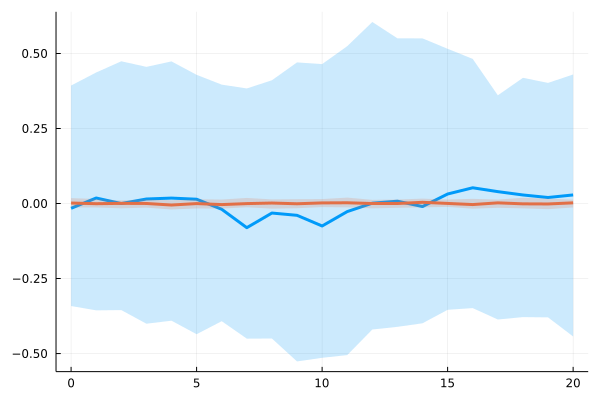

In [15]:
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(m, p_d, p_f) # Solution to the first-order RBC
sol_2 = generate_perturbation(m, p_d, p_f, Val(2)) # Solution to the second-order RBC

# Simulate multiple trajectories with T observations
T = 20
trajectories = 40

# draw from ergodic for each simulation
x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))

# Solve multiple trajectories and plot an ensemble
ensemble_results = solve(EnsembleProblem(problem), DirectIteration(), EnsembleThreads();
                 trajectories)
plot(EnsembleSummary(ensemble_results))

# Calculate sequence of observables

In [16]:
# Simulate T observations
T = 20

p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC

x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))
sim = solve(problem, DirectIteration())
ϵ = sim.W # store the underlying noise in the simulation

# simulated observables
# see https://github.com/SciML/DifferenceEquations.jl/issues/55 for 
# direct support of this datastructure
z = hcat(sim.z...) 

2×21 Matrix{Float64}:
 0.0092253  0.0262029  -0.000714598  …  0.0206403  0.0078339  0.0284731
 0.190317   0.124754    0.146875        0.254382   0.247595   0.298392

# Bayesian estimation with Turing 

In [17]:
using Turing
using Turing: @addlogprob!
Turing.setadbackend(:zygote);

## First-order, marginal likelihood approach

In [18]:
# Turing model definition
@model function rbc_kalman(z, m, p_f, cache)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = LinearStateSpaceProblem(sol, zeros(2), (0, T), observables = z)
    @addlogprob! solve(problem, KalmanFilter()).logpdf
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
turing_model = rbc_kalman(z, model_rbc, p_f, cache) # passing observables from before 

n_samples = 1000
n_adapts = 100
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_1_marginal = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.021875000000000002
└ @ Turing.Inference C:\Users\jbrig\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188


ErrorException("Failing on norm of covariance matrix")

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:   6%|███                                      |  ETA: 0:00:22

ErrorException("Failing on norm of covariance matrix")

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:   8%|████                                     |  ETA: 0:00:24

ErrorException("Failing on norm of covariance matrix")

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 107.87 seconds
Compute duration  = 107.87 seconds
parameters        = α, β
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           α    0.4654    0.0298     0.0009    0.0015   286.8611    0.9990     ⋯
           β    0.9603    0.0104     0.0003    0.0006   231.7691    0.9990     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

## First-order, joint likelihood approach

In [19]:
# Turing model definition
@model function rbc_1_joint(z, m, p_f, cache)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0)
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = LinearStateSpaceProblem(sol, zeros(2), (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
turing_model = rbc_1_joint(z, model_rbc, p_f, cache) # passing observables from before 

n_samples = 1000
n_adapts = 100
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_1_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\jbrig\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:53


Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 526.89 seconds
Compute duration  = 526.89 seconds
parameters        = α, β, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.4791    0.0253     0.0008    0.0014    262.6304    1.0060    ⋯
           β    0.9595    0.0090     0.0003    0.0004    553.2220 

## Second-order, joint likelihood approach

In [20]:
# Turing model definition
@model function rbc_2_joint(z, m, p_f, cache)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0) # add noise to the estimation
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(2); cache)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = QuadraticStateSpaceProblem(sol, zeros(2), (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf
end
cache = SolverCache(model_rbc, Val(2),  [:α, :β])
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
turing_model = rbc_2_joint(z, model_rbc, p_f, cache) # passing observables from before 

n_samples = 1000
n_adapts = 100
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_2_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jbrig\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\jbrig\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:11:14


Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 707.84 seconds
Compute duration  = 707.84 seconds
parameters        = α, β, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.4776    0.0238     0.0008    0.0012    327.9429    1.0114    ⋯
           β    0.9594    0.0087     0.0003    0.0003    649.9856 

## Plotting the estimated latent states

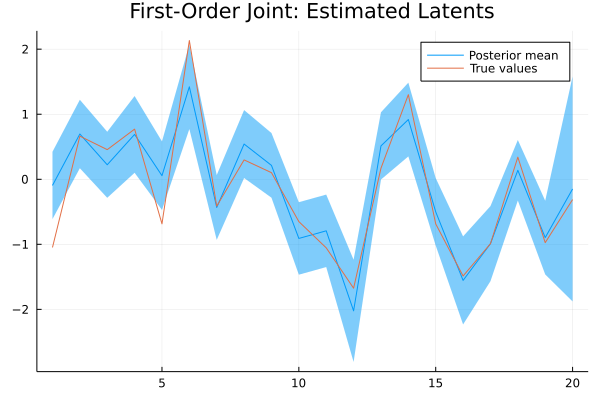

In [21]:
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_1_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[2:end], ribbon=2 * ϵ_std[2:end], label="Posterior mean", title = "First-Order Joint: Estimated Latents")
plot!(ϵ', label="True values")

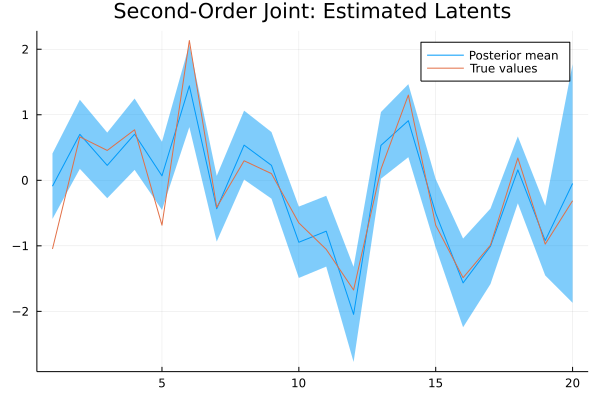

In [22]:
ϵ_chain = sort(chain_2_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[2:end], ribbon=2 * ϵ_std[2:end], label="Posterior mean", title = "Second-Order Joint: Estimated Latents")
plot!(ϵ', label="True values")